In [ ]:
import math
from functools import partial

import jax
import jax.numpy as jnp

from jaxtyping import Array, Float, PRNGKeyArray

import matplotlib.pyplot as plt

key = jax.random.key(0)

## Dataset generation

In [2]:
# lattice parameters
A = 3.16
C = 3.17
lattice_vectors = jnp.array([
    [A, 0, 0],
    [A * jnp.cos(2 * jnp.pi / 3), A * jnp.sin(2 * jnp.pi / 3), 0],
    [0, 0, C]
]) # Angstrom

# atom parameters
eff_radius_Mo = 0.35
eff_radius_S = 0.5

strength_Mo = 42.
strength_S = 16.

vac_rate_Mo = 0.05
vac_rate_S = 0.4

Mo_feature = {
    "eff_radius": eff_radius_Mo,
    "strength": strength_Mo,
    "vac_rate": vac_rate_Mo
}
S_feature = {
    "eff_radius": eff_radius_S,
    "strength": strength_S,
    "vac_rate": vac_rate_S
}

position_displacement = 0.02

# Poisson noise parameter
num_elec_Mo = 8

# Gaussian noise parameters
noise_mu = 7.
noise_sigma = 3.

# Parameters for data generation
width = 64
height = 64
pixel_size = 0.15 # Angstrom
dot_size = 0.15 # Angstrom, For classification labels

In [3]:
b_Mo = jnp.array([0, 0, 0])
b_S1 = jnp.array([(A / jnp.sqrt(3)) * jnp.cos(jnp.pi / 6), (A / jnp.sqrt(3)) * jnp.sin(jnp.pi / 6), C/2])
b_S2 = jnp.array([(A / jnp.sqrt(3)) * jnp.cos(jnp.pi / 6), (A / jnp.sqrt(3)) * jnp.sin(jnp.pi / 6), -C/2])

def generate_lattice(sizes, lattice_vectors, basis):
    b_Mo, b_S1, b_S2 = basis
    i, j = jnp.indices(sizes, sparse = True)
    x = i[..., jnp.newaxis] * lattice_vectors[0]
    y = j[..., jnp.newaxis] * lattice_vectors[1]
    p = (x + y).reshape(-1, 3)
    positions_Mo = p + b_Mo
    positions_S1 = p + b_S1
    positions_S2 = p + b_S2
    return positions_Mo, positions_S1, positions_S2
    

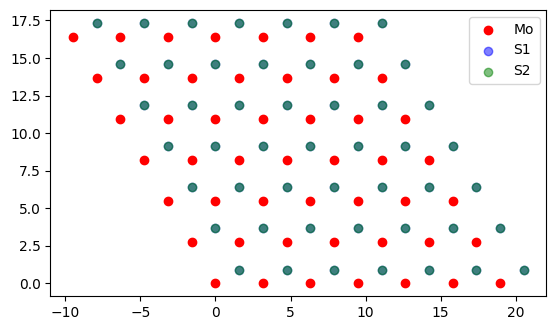

In [4]:
L = math.ceil((pixel_size * jnp.sqrt(width ** 2 + height ** 2)) / (A * (jnp.sqrt(3) / 2))) + 2

positions_Mo, positions_S1, positions_S2 = generate_lattice([L, L], lattice_vectors, (b_Mo, b_S1, b_S2))

plt.scatter(positions_Mo[:,0], positions_Mo[:,1], c='red', label="Mo")
plt.scatter(positions_S1[:,0], positions_S1[:,1], alpha=0.5, c='blue', label="S1")
plt.scatter(positions_S2[:,0], positions_S2[:,1], alpha=0.5, c='green', label="S2")
plt.axis('image')
plt.legend()
plt.show()

In [100]:
def create_image(
    width,
    height,
    positions,
    radius,
    strength,
    pixel_size,
    patch_radius
):
    padding = 2 * patch_radius + 5
    
    img_h = height + 2 * padding
    img_w = width  + 2 * padding
    image = jnp.zeros((img_w, img_h))
    
    center_x = width  // 2 + padding
    center_y = height // 2 + padding
    
    for x, y, _ in positions:
        idx0_x = int(jnp.round(x / pixel_size))
        idx0_y = int(jnp.round(y / pixel_size))
        
        x_idx = idx0_x + center_x
        y_idx = idx0_y + center_y
        
        dx = x - idx0_x * pixel_size
        dy = y - idx0_y * pixel_size
        
        x_low, x_high = x_idx - patch_radius, x_idx + patch_radius + 1
        y_low, y_high = y_idx - patch_radius, y_idx + patch_radius + 1
        
        def gaussian(i, j):
            x_dist = (i - patch_radius) * pixel_size - dx
            y_dist = (j - patch_radius) * pixel_size - dy
            return strength * jnp.exp(-(x_dist**2 + y_dist**2) / (2 * radius**2))
            
        patch = jnp.fromfunction(
            gaussian,
            (2 * patch_radius + 1, 2 * patch_radius + 1)
        )
        image = image.at[x_low:x_high, y_low:y_high].add(patch)
        
    return image[padding: padding + width,
                 padding: padding + height]

def generate_dataset(
    key,
    width,
    height,
    pixel_size,
    lattice_vectors,
    lattice_structure,
    position_displacement,
    Mo_feature,
    S_feature,
    dot_size
):
    # centering
    pos_Mo, pos_S1, pos_S2 = lattice_structure
    center = (jnp.mean(pos_Mo) + jnp.mean(pos_S1) + jnp.mean(pos_S2)) / 3
    pos_Mo_centered = pos_Mo - center
    pos_S1_centered = pos_S1 - center
    pos_S2_centered = pos_S2 - center

    a1 = lattice_vectors[0]
    a2 = lattice_vectors[1]
    
    # offset
    subkey1, subkey2, key = jax.random.split(key, 3)
    offset = jax.random.uniform(subkey1) * a1 + jax.random.uniform(subkey2) * a2
    
    pos_Mo_shifted = pos_Mo_centered - offset
    pos_S1_shifted = pos_S1_centered - offset
    pos_S2_shifted = pos_S2_centered - offset
    
    # rotation
    angle_key, key = jax.random.split(key)
    rand_angle = (2 * jnp.pi / 3) * jax.random.uniform(angle_key)
    
    cos = jnp.cos(rand_angle)
    sin = jnp.sin(rand_angle)
    rot_mat = jnp.array([
        [cos, -sin, 0],
        [sin, cos, 0],
        [0, 0, 1]
    ])
    
    pos_Mo_rotated = jnp.einsum("ij,nj->ni", rot_mat, pos_Mo_shifted)
    pos_S1_rotated = jnp.einsum("ij,nj->ni", rot_mat, pos_S1_shifted)
    pos_S2_rotated = jnp.einsum("ij,nj->ni", rot_mat, pos_S2_shifted)
    
    gaussian_size = jnp.max(jnp.array([
        Mo_feature["eff_radius"],
        S_feature["eff_radius"]
    ]))
    
    patch_radius = math.ceil(4 * gaussian_size / pixel_size)
    
    # cropping
    (minx, maxx) = (-(width / 2 + patch_radius) * pixel_size, (width / 2 + patch_radius) * pixel_size)
    (miny, maxy) = (-(height / 2 + patch_radius) * pixel_size, (height / 2 + patch_radius) * pixel_size)
    def crop(pos):
        x_cond = (pos[:, 0] >= minx) & (pos[:, 0] <= maxx)
        y_cond = (pos[:, 1] >= miny) & (pos[:, 1] <= maxy)
        valid_cond = x_cond & y_cond
        return pos[valid_cond]
    
    pos_Mo_cropped = crop(pos_Mo_rotated)
    pos_S1_cropped = crop(pos_S1_rotated)
    pos_S2_cropped = crop(pos_S2_rotated)
    
    Mo_key, S1_key, S2_key, key = jax.random.split(key, 4)
    pos_Mo_final = pos_Mo_cropped + position_displacement * jax.random.normal(Mo_key, pos_Mo_cropped.shape)
    pos_S1_final = pos_S1_cropped + position_displacement * jax.random.normal(S1_key, pos_S1_cropped.shape)
    pos_S2_final = pos_S2_cropped + position_displacement * jax.random.normal(S2_key, pos_S2_cropped.shape)
    
    Mo_key, S1_key, S2_key, key = jax.random.split(key, 4)
    Mo_survived = jax.random.uniform(Mo_key, (pos_Mo_final.shape[0],)) > Mo_feature["vac_rate"]
    S1_survived = jax.random.uniform(S1_key, (pos_S1_final.shape[0],)) > S_feature["vac_rate"]
    S2_survived = jax.random.uniform(S2_key, (pos_S2_final.shape[0],)) > S_feature["vac_rate"]
    
    Mo_dead = pos_Mo_cropped[~Mo_survived]
    Mo_single = pos_Mo_cropped[Mo_survived]
    S_dead = pos_S1_cropped[~(S1_survived | S2_survived)]
    S_single = pos_S1_cropped[jnp.logical_xor(S1_survived, S2_survived)]
    S_double = pos_S1_cropped[S1_survived & S2_survived]
    pos_full = jnp.concatenate([pos_Mo_cropped, pos_S1_cropped], axis=0)
    
    Mo_image = create_image(
        width, height,
        pos_Mo_final[Mo_survived],
        Mo_feature["eff_radius"],
        Mo_feature["strength"],
        pixel_size,
        patch_radius
    )
    S1_image = create_image(
        width, height,
        pos_S1_final[S1_survived],
        S_feature["eff_radius"],
        S_feature["strength"],
        pixel_size,
        patch_radius
    )
    S2_image = create_image(
        width, height,
        pos_S2_final[S2_survived],
        S_feature["eff_radius"],
        S_feature["strength"],
        pixel_size,
        patch_radius
    )
    generated_image = Mo_image + S1_image + S2_image
    image_kwargs = dict(
        width=width,
        height=height,
        radius=dot_size,
        strength=1,
        pixel_size=pixel_size,
        patch_radius=patch_radius
    )
    class_labels = jnp.stack(
        [
            create_image(positions=Mo_dead, **image_kwargs),
            create_image(positions=Mo_single, **image_kwargs),
            create_image(positions=S_dead, **image_kwargs),
            create_image(positions=S_single, **image_kwargs),
            create_image(positions=S_double, **image_kwargs),
            create_image(positions=pos_full, **image_kwargs),
        ],
        axis=0
    )
    
    return generated_image, class_labels

labels = [
    "Mo Vacancy",
    "Single Mo",
    "S Vacancy",
    "Single S",
    "Double S",
    "Full Lattice"
]

In [106]:
def _create_image_internal(
    width,          # Will be static when called from JITted parent
    height,         # Will be static when called from JITted parent
    positions,      # JAX array
    mask,           # JAX array or None
    radius,         # Float or JAX array
    strength,       # Float or JAX array
    pixel_size,     # Will be static
    patch_radius    # Will be static integer
):
    """Internal helper to create image, called by JITted generate_dataset."""
    # These calculations will now use static values for width, height, patch_radius
    padding = 2 * patch_radius + 5

    img_h = height + 2 * padding
    img_w = width  + 2 * padding

    # Shape is now concrete during trace time
    initial_image = jnp.zeros((img_w, img_h), dtype=jnp.float32)

    center_x = width  // 2 + padding
    center_y = height // 2 + padding

    num_positions = positions.shape[0]

    # Create grid coordinates for a single patch (relative to patch center)
    patch_coords = jnp.arange(-patch_radius, patch_radius + 1) * pixel_size
    grid_x, grid_y = jnp.meshgrid(patch_coords, patch_coords, indexing='ij')

    def loop_body(i, current_image):
        x, y = positions[i, 0], positions[i, 1]
        idx0_x = jnp.round(x / pixel_size).astype(jnp.int32)
        idx0_y = jnp.round(y / pixel_size).astype(jnp.int32)
        x_idx = idx0_x + center_x
        y_idx = idx0_y + center_y
        dx = x - idx0_x * pixel_size
        dy = y - idx0_y * pixel_size
        x_low, x_high = x_idx - patch_radius, x_idx + patch_radius + 1
        y_low, y_high = y_idx - patch_radius, y_idx + patch_radius + 1

        x_dist = grid_x - dx
        y_dist = grid_y - dy
        patch = strength * jnp.exp(-(x_dist**2 + y_dist**2) / (2 * radius**2))

        is_valid = True if mask is None else mask[i]

        def add_patch(img):
            # Consider using jax.lax.dynamic_update_slice for safety if indices
            # might go out of bounds, though padding should help.
            # For now, using .at[] assuming indices are safe.
            return img.at[x_low:x_high, y_low:y_high].add(patch)

        def do_nothing(img):
            return img

        updated_image = jax.lax.cond(is_valid, add_patch, do_nothing, current_image)
        return updated_image

    final_image = jax.lax.fori_loop(0, num_positions, loop_body, initial_image)

    return final_image[padding: padding + width,
                       padding: padding + height]


# Original generate_dataset function definition (NO JIT DECORATOR HERE)
# It now calls _create_image_internal instead of create_image_jit
def generate_dataset(
    key,
    width,              # Will be static
    height,             # Will be static
    pixel_size,         # Make static
    lattice_vectors,    # Can be dynamic (JAX array)
    lattice_structure,  # Can be dynamic (Tuple of JAX arrays)
    position_displacement, # Make static
    Mo_feature,         # Make static (dict treated as pytree)
    S_feature,          # Make static (dict treated as pytree)
    dot_size            # Make static
):
    # ... (centering, offset, rotation code as before) ...
    pos_Mo, pos_S1, pos_S2 = lattice_structure
    center = (jnp.mean(pos_Mo, axis=0) + jnp.mean(pos_S1, axis=0) + jnp.mean(pos_S2, axis=0)) / 3.0
    pos_Mo_centered = pos_Mo - center
    pos_S1_centered = pos_S1 - center
    pos_S2_centered = pos_S2 - center

    a1 = lattice_vectors[0]
    a2 = lattice_vectors[1]

    subkey1, subkey2, key = jax.random.split(key, 3)
    # Ensure offset shape is (1, 3) for broadcasting if vectors are (3,)
    a1 = a1.reshape(1, -1)
    a2 = a2.reshape(1, -1)
    offset = jax.random.uniform(subkey1, shape=(1, a1.shape[1])) * a1 + jax.random.uniform(subkey2, shape=(1, a2.shape[1])) * a2
    pos_Mo_shifted = pos_Mo_centered - offset
    pos_S1_shifted = pos_S1_centered - offset
    pos_S2_shifted = pos_S2_centered - offset

    angle_key, key = jax.random.split(key)
    rand_angle = (2 * jnp.pi / 3) * jax.random.uniform(angle_key)
    cos_a = jnp.cos(rand_angle)
    sin_a = jnp.sin(rand_angle)
    rot_mat_2d = jnp.array([[cos_a, -sin_a],[sin_a, cos_a]])
    pos_Mo_rotated_xy = jnp.einsum("ij,nj->ni", rot_mat_2d, pos_Mo_shifted[:, :2])
    pos_S1_rotated_xy = jnp.einsum("ij,nj->ni", rot_mat_2d, pos_S1_shifted[:, :2])
    pos_S2_rotated_xy = jnp.einsum("ij,nj->ni", rot_mat_2d, pos_S2_shifted[:, :2])
    pos_Mo_rotated = pos_Mo_shifted.at[:, :2].set(pos_Mo_rotated_xy)
    pos_S1_rotated = pos_S1_shifted.at[:, :2].set(pos_S1_rotated_xy)
    pos_S2_rotated = pos_S2_shifted.at[:, :2].set(pos_S2_rotated_xy)

    # --- Calculate patch radius ---
    # Since pixel_size, Mo_feature, S_feature are static, gaussian_size
    # and patch_radius will be computed as concrete values during trace.
    gaussian_size = jnp.maximum(Mo_feature["eff_radius"], S_feature["eff_radius"])
    patch_radius = jnp.ceil(4.0 * gaussian_size / pixel_size).astype(jnp.int32)
    # Also calculate label patch radius if different
    label_patch_radius = jnp.ceil(4.0 * dot_size / pixel_size).astype(jnp.int32) # Assuming similar logic for dot_size

    # --- Cropping Boundaries ---
    # width, height, pixel_size, patch_radius are static/concrete here
    half_width_pixels = width / 2.0
    half_height_pixels = height / 2.0
    # Use the larger patch radius for boundary definition
    max_patch_radius_float = jnp.maximum(patch_radius, label_patch_radius).astype(jnp.float32)
    minx = -(half_width_pixels + max_patch_radius_float) * pixel_size
    maxx =  (half_width_pixels + max_patch_radius_float) * pixel_size
    miny = -(half_height_pixels + max_patch_radius_float) * pixel_size
    maxy =  (half_height_pixels + max_patch_radius_float) * pixel_size

    # --- Create masks ---
    def get_in_bounds_mask(pos):
        x_cond = (pos[:, 0] >= minx) & (pos[:, 0] <= maxx)
        y_cond = (pos[:, 1] >= miny) & (pos[:, 1] <= maxy)
        return x_cond & y_cond
    Mo_in_bounds = get_in_bounds_mask(pos_Mo_rotated)
    S1_in_bounds = get_in_bounds_mask(pos_S1_rotated)
    S2_in_bounds = get_in_bounds_mask(pos_S2_rotated) # Assuming S2 uses same bounds logic

    # --- Apply displacement ---
    Mo_key, S1_key, S2_key, key = jax.random.split(key, 4)
    noise_shape_Mo = pos_Mo_rotated.shape
    noise_shape_S1 = pos_S1_rotated.shape
    noise_shape_S2 = pos_S2_rotated.shape
    # position_displacement is static, so this is fine
    pos_Mo_final = pos_Mo_rotated + position_displacement * jax.random.normal(Mo_key, noise_shape_Mo)
    pos_S1_final = pos_S1_rotated + position_displacement * jax.random.normal(S1_key, noise_shape_S1)
    pos_S2_final = pos_S2_rotated + position_displacement * jax.random.normal(S2_key, noise_shape_S2)

    # --- Generate survival masks ---
    # Mo_feature, S_feature are static, rates are concrete values
    Mo_v_key, S1_v_key, S2_v_key, key = jax.random.split(key, 4)
    Mo_survived_rand = jax.random.uniform(Mo_v_key, (pos_Mo_final.shape[0],)) > Mo_feature["vac_rate"]
    S1_survived_rand = jax.random.uniform(S1_v_key, (pos_S1_final.shape[0],)) > S_feature["vac_rate"]
    S2_survived_rand = jax.random.uniform(S2_v_key, (pos_S2_final.shape[0],)) > S_feature["vac_rate"]

    # --- Combine masks ---
    Mo_valid_and_survived = Mo_in_bounds & Mo_survived_rand
    S1_valid_and_survived = S1_in_bounds & S1_survived_rand
    S2_valid_and_survived = S2_in_bounds & S2_survived_rand

    # --- Create main image ---
    # Calls _create_image_internal. width, height, pixel_size, patch_radius are concrete.
    Mo_image = _create_image_internal(
        width, height, pos_Mo_final, mask=Mo_valid_and_survived,
        radius=Mo_feature["eff_radius"], strength=Mo_feature["strength"],
        pixel_size=pixel_size, patch_radius=patch_radius
    )
    S1_image = _create_image_internal(
        width, height, pos_S1_final, mask=S1_valid_and_survived,
        radius=S_feature["eff_radius"], strength=S_feature["strength"],
        pixel_size=pixel_size, patch_radius=patch_radius
    )
    S2_image = _create_image_internal(
        width, height, pos_S2_final, mask=S2_valid_and_survived,
        radius=S_feature["eff_radius"], strength=S_feature["strength"],
        pixel_size=pixel_size, patch_radius=patch_radius
    )
    generated_image = Mo_image + S1_image + S2_image

    # --- Generate Class Labels ---
    Mo_dead_mask = Mo_in_bounds & (~Mo_survived_rand)
    Mo_single_mask = Mo_valid_and_survived
    S_site_in_bounds = S1_in_bounds
    S1_survives = S1_survived_rand
    S2_survives = S2_survived_rand
    S_dead_mask = S_site_in_bounds & (~S1_survives) & (~S2_survives)
    S_single_mask = S_site_in_bounds & jnp.logical_xor(S1_survives, S2_survives)
    S_double_mask = S_site_in_bounds & S1_survives & S2_survives
    pos_full_rotated = jnp.concatenate([pos_Mo_rotated, pos_S1_rotated], axis=0)
    full_in_bounds_mask = jnp.concatenate([Mo_in_bounds, S1_in_bounds], axis=0)

    # dot_size, pixel_size, label_patch_radius are static/concrete
    image_kwargs = dict(
        width=width, height=height,
        radius=dot_size, strength=1.0,
        pixel_size=pixel_size, patch_radius=label_patch_radius # Use specific radius for labels
    )

    # Calls _create_image_internal
    class_labels = jnp.stack(
        [
            _create_image_internal(positions=pos_Mo_rotated, mask=Mo_dead_mask, **image_kwargs),
            _create_image_internal(positions=pos_Mo_rotated, mask=Mo_single_mask, **image_kwargs),
            _create_image_internal(positions=pos_S1_rotated, mask=S_dead_mask, **image_kwargs),
            _create_image_internal(positions=pos_S1_rotated, mask=S_single_mask, **image_kwargs),
            _create_image_internal(positions=pos_S1_rotated, mask=S_double_mask, **image_kwargs),
            _create_image_internal(positions=pos_full_rotated, mask=full_in_bounds_mask, **image_kwargs),
        ],
        axis=0
    )

    return generated_image, class_labels


# --- Create the JITted version using partial ---
# Specify arguments that define shapes or control flow structure as static
# Dictionaries like Mo_feature are treated as 'pytrees' by JAX and
# their structure needs to be static, but their float values can be dynamic *unless*
# they affect things like patch_radius which determine shapes.
# To be safe, let's mark the features, pixel_size, dot_size, and displacement static.
generate_dataset_jitted = partial(jax.jit, static_argnames=(
    'width', 'height', 'pixel_size', 'position_displacement',
    'Mo_feature', 'S_feature', 'dot_size'
    # lattice_vectors and lattice_structure are left dynamic (JAX arrays/pytrees)
))


# Labels definition remains the same
labels = [
    "Mo Vacancy",
    "Single Mo",
    "S Vacancy",
    "Single S",
    "Double S",
    "Full Lattice"
]

NameError: name 'partial' is not defined

In [105]:
key, subkey = jax.random.split(key)
generated_image, class_labels = generate_dataset(
    subkey,
    width,
    height,
    pixel_size,
    lattice_vectors,
    (positions_Mo, positions_S1, positions_S2),
    position_displacement,
    Mo_feature,
    S_feature,
    dot_size
)

plt.figure(figsize=(6, 6))
plt.title("Simulated Image")
plt.imshow(generated_image)
plt.axis('off')
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(6, 9))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(class_labels[idx], cmap='gray')
    ax.set_title(f"{labels[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[])>with<DynamicJaxprTrace>, Traced<ShapedArray(int32[])>with<DynamicJaxprTrace>).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function create_image_jit at C:\Users\pco0511\AppData\Local\Temp\ipykernel_42244\687207749.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments width and radius.
The error occurred while tracing the function create_image_jit at C:\Users\pco0511\AppData\Local\Temp\ipykernel_42244\687207749.py:1 for jit. This concrete value was not available in Python because it depends on the values of the arguments height and radius.

## Denoising Image